In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def plot_precision_recall_vs_treshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Точность")
    plt.plot(thresholds, recalls[:-1], "g-", label="Полнота")
    plt.xlabel("Порог", fontsize=16)
    plt.legend(loc="center left", fontsize=16)
    plt.ylim([0, 1])

def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Полнота", fontsize=16)
    plt.ylabel("Точность", fontsize=16)
    plt.axis([0, 1, 0, 1])

def plot_roc_curve(rates):
    plt.figure(figsize=(10,8))
    for rate in rates:
        plt.plot(rate[0], rate[1], rate[2], linewidth=2, label=rate[3])
    plt.plot([0, 1], [0, 1], 'k--', label="Случайная классификация")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("Доля ложноположительных классификаций")
    plt.ylabel("Доля истинно положительных классификаций")
    plt.legend(loc="lower right", fontsize=16)

def draw_digit(X, i):
    some_digit = X[i]
    some_digit_image = some_digit.reshape(28,28)
    plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    
    return some_digit

In [2]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


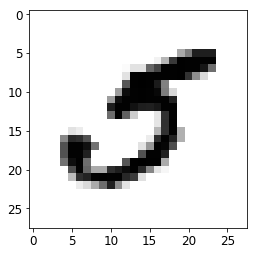

In [4]:
i = 36000

some_digit = draw_digit(X, i)

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


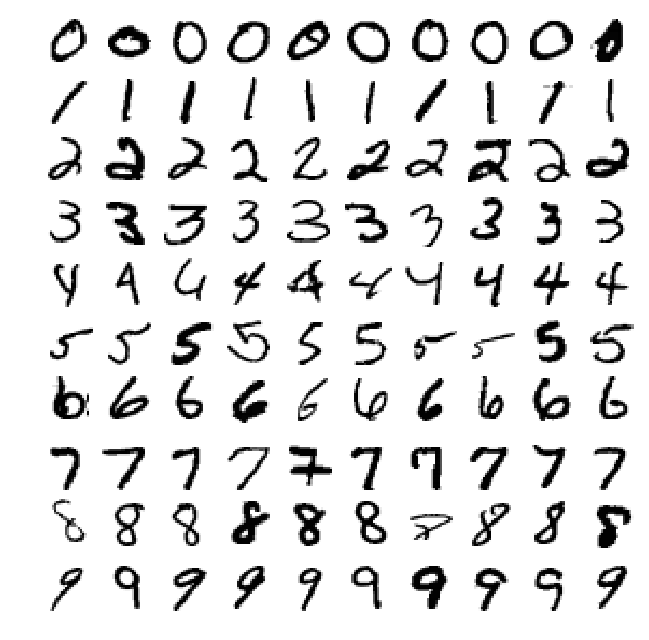

In [7]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [8]:
# обучающие и тестовые X и y
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [10]:
# Для начала попробуем угадывать 5

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
# Бинарный классификатор. Стохастический градиентный спуск

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [13]:
# поглядим, для начала, на точность

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will

array([ 0.9502 ,  0.96565,  0.96495])

In [14]:
# получим прогнозы по всем тестовым блокам

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will

In [15]:
# Матрица неточностей (строки - фактические классы, столбцы - спрогнозированные):
# TN FN
# FP TP

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Точноть TP / (TP + FP)
print(precision_score(y_train_5, y_train_pred)) 

# Полнота TP / (TP + FN)
print(recall_score(y_train_5, y_train_pred))

# Мера (F1) TP / (TP + (FN + FP) / 2)
print(f1_score(y_train_5, y_train_pred))

0.768713502035
0.801328168235
0.784682080925


In [17]:
# Узнаем сумму очков для образца
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 161855.74572176])

In [18]:
# Поднимаем порог принятия решений. Выше порог - выше точность, ниже полнота
threshold = 0 # порог по умолчанию
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]
[False]


In [19]:
# Вычисление порога принятия решений

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will

array([ -434076.49813641, -1825667.15281624,  -767086.76186905, ...,
        -867191.25267994,  -565357.11420164,  -366599.16018198])

Saving figure precision_vs_recall_vs_treshold_plot


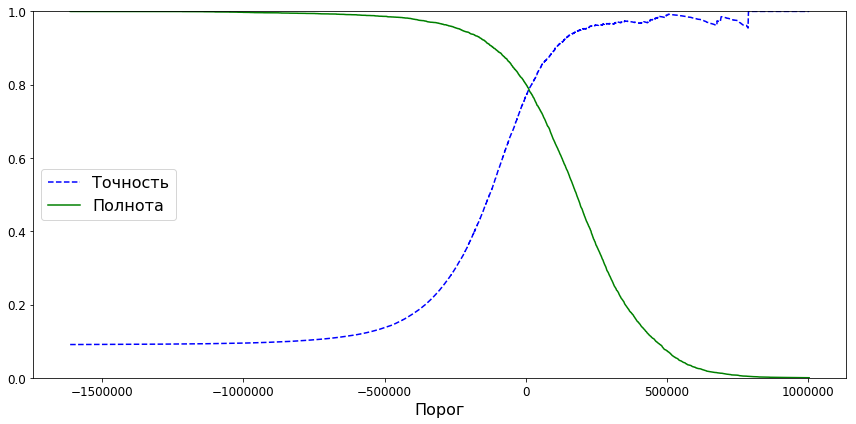

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plot_precision_recall_vs_treshold(precisions, recalls, thresholds)
save_fig("precision_vs_recall_vs_treshold_plot")

Saving figure precision_vs_recall_plot


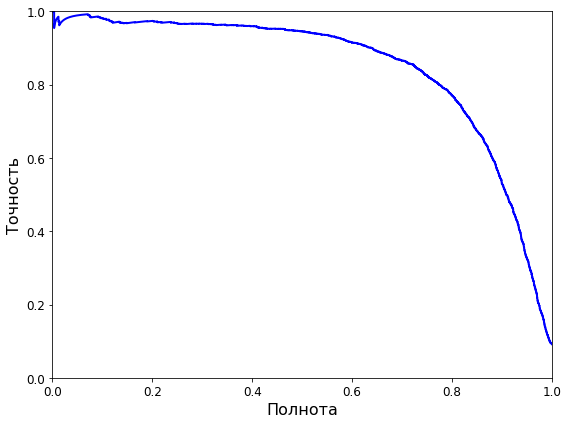

In [21]:
# Кривая PR (Precision/Rate)

plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")

In [22]:
# Возьмём данные порога в 70000 и проверим точность и полноту
y_train_pred_90 = (y_scores > 70000)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.865920511649
0.699317469102


Saving figure ROC_curve


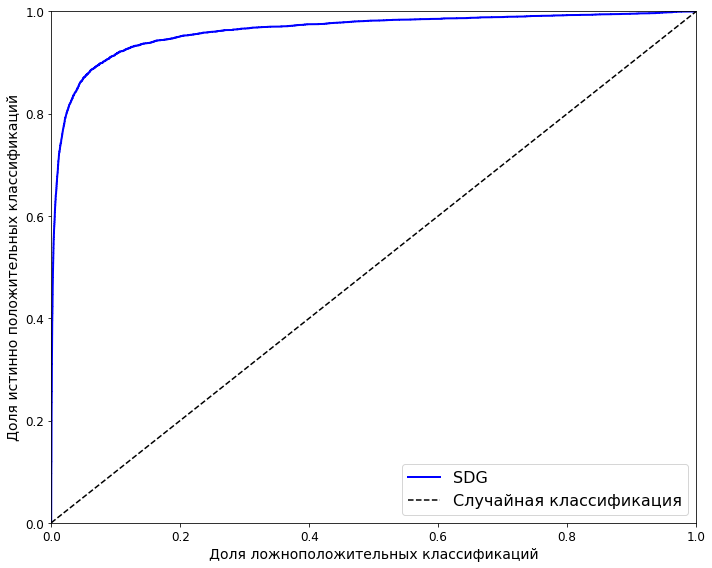

In [23]:
# ROC (Receiver Operating Characteristic, рабочая характеристика приёмника)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plot_roc_curve([(fpr, tpr, "b", "SDG")])
save_fig("ROC_curve")

In [24]:
# AUC (Area Under the Curve, площадь под кривой) - чем ближе к 1, тем лучше

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96244965559671547

In [25]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# вероятности
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
# вероятность положительного класса
y_scores_forest = y_probas_forest[:, 1]

In [26]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

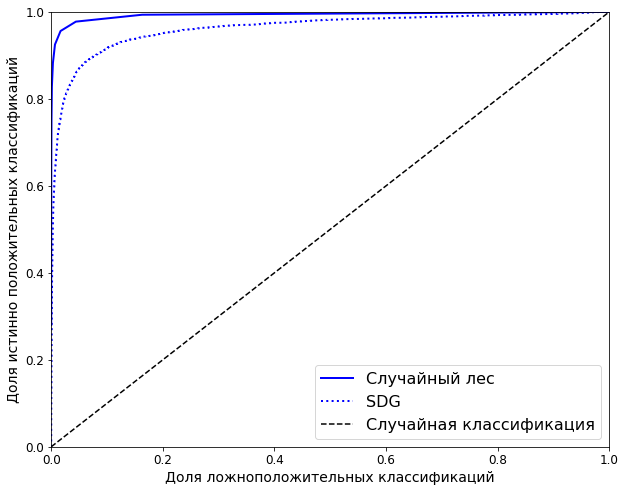

In [27]:
# ROC для SGD и для Random Forest

plot_roc_curve([(fpr_forest, tpr_forest, "b", "Случайный лес"), (fpr, tpr, "b:", "SDG")])

In [28]:
# AUC для случайного леса
roc_auc_score(y_train_5, y_scores_forest)

0.99312433660038291

In [29]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [30]:
# Матрица неточностей, точность, полнота и мера для случайного леса
print(confusion_matrix(y_train_5, y_train_pred_forest))

# Точноть TP / (TP + FP)
print(precision_score(y_train_5, y_train_pred_forest)) 

# Полнота TP / (TP + FN)
print(recall_score(y_train_5, y_train_pred_forest))

# Мера (F1) TP / (TP + (FN + FP) / 2)
print(f1_score(y_train_5, y_train_pred_forest))

[[54512    67]
 [  931  4490]]
0.985297344744
0.828260468548
0.899979955903


In [31]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_train_pred_forest)

Saving figure forest_precision_vs_recall_plot


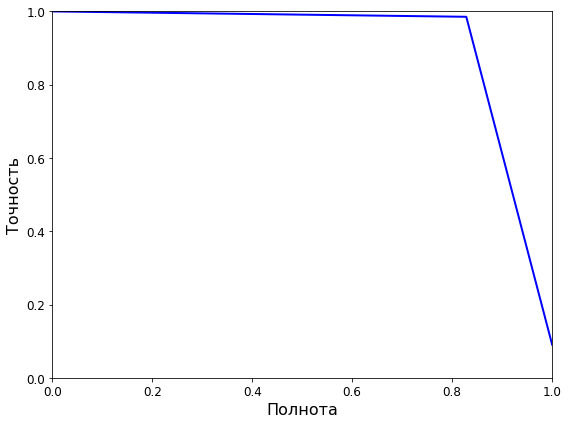

In [32]:
# Кривая PR для случайных лесов

plot_precision_vs_recall(precisions_forest, recalls_forest)
save_fig("forest_precision_vs_recall_plot")

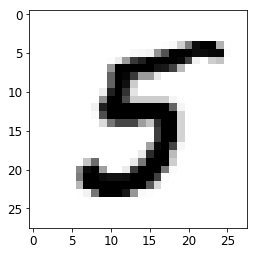

In [33]:
some_digit = draw_digit(X_train, 4156)

In [34]:
sgd_clf.fit(X_train, y_train)

c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [35]:
sgd_clf.predict([some_digit])

array([ 5.])

In [36]:
# прогноз выдаётся для каждого класса. Создаётся 10 двоичных классификаторов!
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

best_score_index = np.argmax(some_digit_scores)
sgd_clf.classes_[best_score_index]

[[ -716626.70005616  -379527.03774261  -782910.5155656   -416150.87244202
   -341698.47353213   291590.22988948  -190424.03020875 -1101406.05144929
   -183931.16186127  -375321.81086528]]


5.0

In [37]:
# по умолчанию для SGD используется стратегия OneVsAll
# можно использовать стратегию OneVsOne и создавать классы для каждой пар классов

from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))

len(ovo_clf.estimators_)  # 45 классов N * (N - 1) / 2

c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will

c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will

c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will

[ 5.]


c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


45

In [38]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [39]:
# Классификаторы методом случайных лесов сами способны группиковать образцы в множество классов
# Вероятность для каждого:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [40]:
# перекрётская проверка
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.94041192,  0.93879694,  0.93949092])

In [41]:
# попробуем отмасштабировать данные, чтобы увеличить правильность

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Проблемы с памятью, пока выключим
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

X_train_scaled = X_train

In [42]:
# посмотрим на матрицу неточностей по всему набору

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\users\yithi_000\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will

array([[5604,    2,   81,   25,    8,   44,   32,    9,  115,    3],
       [   1, 6292,   72,   54,   20,   22,    8,    8,  262,    3],
       [  59,   73, 5016,  218,   68,   25,   82,   58,  344,   15],
       [  40,   16,  148, 5315,   19,  199,   23,   41,  297,   33],
       [  24,   26,  145,   39, 4746,   22,   63,   49,  502,  226],
       [  73,   25,   74,  375,   62, 3868,   91,   22,  771,   60],
       [  50,   19,  128,   13,   84,  105, 5369,    8,  140,    2],
       [  65,   19,   69,  117,  100,   18,    2, 5641,  112,  122],
       [  47,   96,  127,  196,   77,  135,   30,   23, 5088,   32],
       [  58,   45,   59,  199,  233,   59,    2,  385,  725, 4184]], dtype=int64)

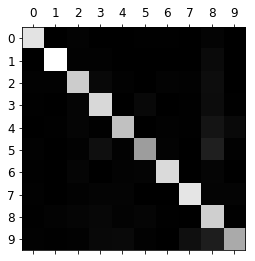

In [43]:
# отрисуем матрицу неточностей для наглядности
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xticks(range(0, len(conf_mx)))
plt.yticks(range(0, len(conf_mx)))
plt.show()

In [44]:
# посмотрим на ошибки
rows_sum = conf_mx.sum(axis=1, keepdims=True)  # число изображений в каждом классе
norm_conf_mx = conf_mx / rows_sum

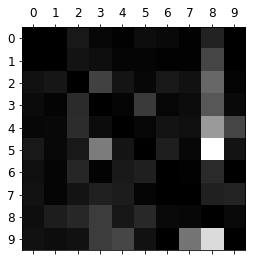

In [45]:
np.fill_diagonal(norm_conf_mx, 0)  # запонлим диагональ нулям, что б остались только ошибки
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xticks(range(0, len(conf_mx)))
plt.yticks(range(0, len(conf_mx)))
plt.show()

Saving figure error_analysis_digits_plot


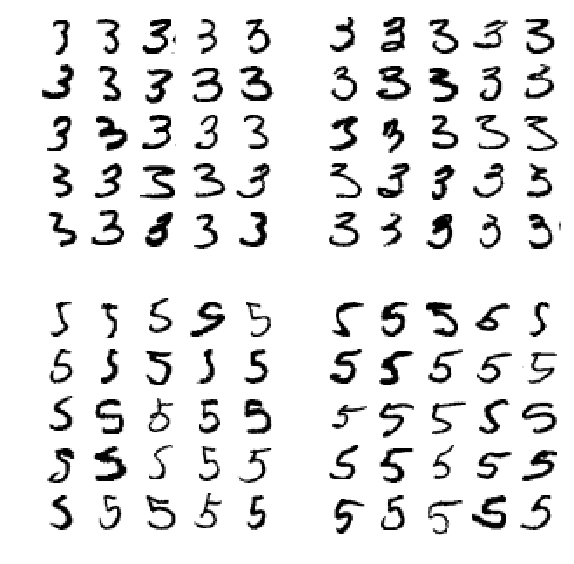

In [46]:
# отрисуем несколько 3 и 5

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]  # 3, классифицированные как 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]  # 3, классифицированные как 5

X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]  # 5, классифицированные как 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]  # 5, классифицированные как 5

plt.figure(figsize=(8,8))

plt.subplot(221);
plot_digits(X_aa[:25], images_per_row=5)

plt.subplot(222) 
plot_digits(X_ab[:25], images_per_row=5)

plt.subplot(223);
plot_digits(X_ba[:25], images_per_row=5)

plt.subplot(224) 
plot_digits(X_bb[:25], images_per_row=5)

save_fig("error_analysis_digits_plot")
plt.show()

In [47]:
# многозначная классификация

from sklearn.neighbors import  KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [48]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [49]:
# Вычислим меру F1 (вычисляется несколько часов. Не будем пока делать)
%whos
# y_train_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score(y_multilabel, y_train_pred, average="macro")

Variable                            Type                      Data/Info
-----------------------------------------------------------------------
CHAPTER_ID                          str                       classification
KNeighborsClassifier                ABCMeta                   <class 'sklearn.neighbors<...>on.KNeighborsClassifier'>
OneVsOneClassifier                  type                      <class 'sklearn.multiclass.OneVsOneClassifier'>
PROJECT_ROOT_DIR                    str                       .
RandomForestClassifier              ABCMeta                   <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SGDClassifier                       ABCMeta                   <class 'sklearn.linear_mo<...>_gradient.SGDClassifier'>
StandardScaler                      type                      <class 'sklearn.preproces<...>ing.data.StandardScaler'>
X                                   ndarray                   70000x784: 54880000 elems, type `uint8`, 54880000 bytes (52.33764648437

In [50]:
# Многовыходовая классификация

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


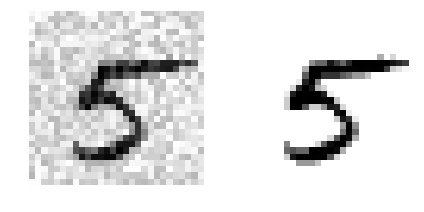

In [51]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()